In [76]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import re
import matplotlib.pyplot as plt

def plot_rtos_log(filename, title="RTOS Gantt Chart"):
    # --- Step 1: Parse the log for events ---
    events = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            tim2_interrupt = re.search(r'Tim2 running\. Time: (\d+)', line)
            tim3_interrupt = re.search(r'Tim3 running\. Time: (\d+)', line)
            start_long = re.match(r'Long task started\. Time: (\d+)', line)
            pause_long = re.match(r'Long task paused\. Time: (\d+)', line)
            resume_long = re.match(r'Long task resumed\. Time: (\d+)', line)
            finish_long = re.match(r'Long task finished\. Time: (\d+)', line)
            start_short = re.match(r'Short task started\. Time: (\d+)', line)
            pause_short = re.match(r'Short task paused\. Time: (\d+)', line)
            resume_short = re.match(r'Short task resumed\. Time: (\d+)', line)
            finish_short = re.match(r'Short task finished\. Time: (\d+)', line)
            start_dep = re.match(r'Dependent task started. Time: (\d+)', line)
            pause_dep = re.match(r'Dependent task paused\. Time: (\d+)', line)
            resume_dep = re.match(r'Dependent task resumed\. Time: (\d+)', line)
            finish_dep = re.match(r'Dependent task finished. Time: (\d+)', line)

            if tim2_interrupt:
                events.append({'task': 'TIM2', 'action': 'temp_interrupt', 'time': int(tim2_interrupt.group(1))})
            elif tim3_interrupt:
                events.append({'task': 'TIM3', 'action': 'temp_interrupt', 'time': int(tim3_interrupt.group(1))})
            elif start_long:
                events.append({'task': 'Long Task', 'action': 'start', 'time': int(start_long.group(1))})
            elif pause_long:
                events.append({'task': 'Long Task', 'action': 'end', 'time': int(pause_long.group(1))})
            elif resume_long:
                events.append({'task': 'Long Task', 'action': 'start', 'time': int(resume_long.group(1))})
            elif finish_long:
                events.append({'task': 'Long Task', 'action': 'end', 'time': int(finish_long.group(1))})
            elif start_short:
                events.append({'task': 'Short Task', 'action': 'start', 'time': int(start_short.group(1))})
            elif pause_short:
                events.append({'task': 'Short Task', 'action': 'end', 'time': int(pause_short.group(1))})
            elif resume_short:
                events.append({'task': 'Short Task', 'action': 'start', 'time': int(resume_short.group(1))})
            elif finish_short:
                events.append({'task': 'Short Task', 'action': 'end', 'time': int(finish_short.group(1))})
            elif start_dep:
                events.append({'task': 'Dependent Task', 'action': 'start', 'time': int(start_dep.group(1))})
            elif pause_dep:
                events.append({'task': 'Dependent Task', 'action': 'end', 'time': int(pause_dep.group(1))})
            elif resume_dep:
                events.append({'task': 'Dependent Task', 'action': 'start', 'time': int(resume_dep.group(1))})
            elif finish_dep:
                events.append({'task': 'Dependent Task', 'action': 'end', 'time': int(finish_dep.group(1))})

    # --- Step 2: Group into task durations ---
    task_times = {'Long Task': [], 'Short Task': [], 'Dependent Task': []}
    running_tasks = {}
    single_events = {'TIM3': [], 'TIM2': []}

    for event in events:
        task = event['task']
        action = event['action']
        time = event['time']

        if action == 'start':
            running_tasks[task] = time
        elif action == 'end':
            if task in running_tasks:
                start_time = running_tasks.pop(task)
                task_times[task].append((start_time, time))
        elif action == 'temp_interrupt':
            single_events[task].append(time)

    # --- Step 3: Plot using matplotlib ---
    fig, ax = plt.subplots(figsize=(10, 5))

    colors = {'Long Task': 'skyblue', 'Short Task': 'lightcoral', 'Dependent Task': 'purple'}
    y_pos = {'Long Task': 0, 'Short Task': 1, 'Dependent Task': 2}

    for task, periods in task_times.items():
        for start, end in periods:
            ax.barh(y_pos[task], end - start, left=start, color=colors[task], edgecolor='black', label=task)

    for event_name, times in single_events.items():
        dot_size = 100 if event_name == 'TIM2' else 10
        label = f'{event_name} Interrupt'
        ax.scatter(times, [2.5] * len(times), label=label, marker='.', edgecolor='black', facecolor='none', s=dot_size)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_yticks([y_pos['Long Task'], y_pos['Short Task'], y_pos['Dependent Task']])
    ax.set_yticklabels(['Long Task', 'Short Task', 'Dependent Task'])
    ax.set_xlabel('Time (ticks)')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


### Only long tasks with no interrupts from TIM2 or TIM3:

The graph should show a continuous block of execution for long tasks, managed by
the round-robin scheduler without any preemption.


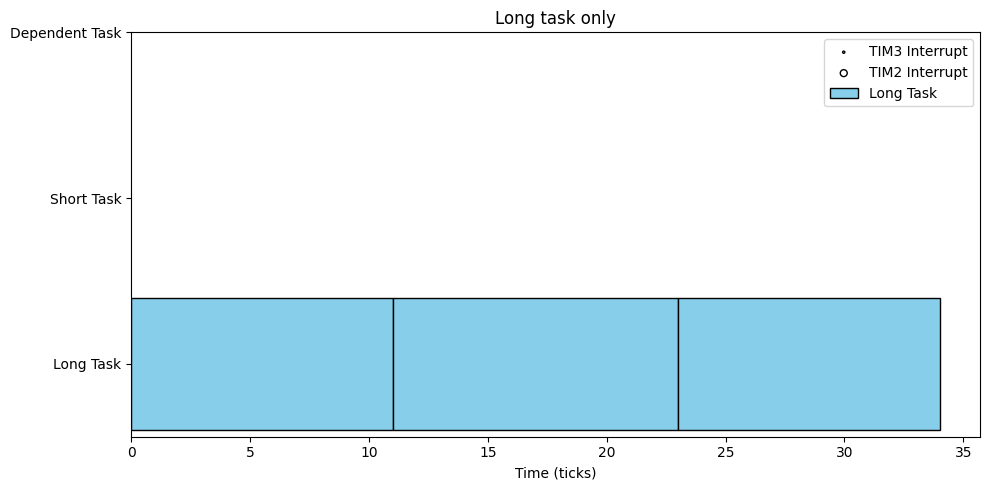

In [78]:
plot_rtos_log("long_task_only.txt", title="Long task only")


### Long tasks with interrupts from TIM3:

Long tasks are running, but TIM3 interrupts occur periodically, triggering short
task queuing. We expect long tasks to be running from start to finish(with no
interrupts in between), and the short tasks will pile up and gets run after the
long task finish.


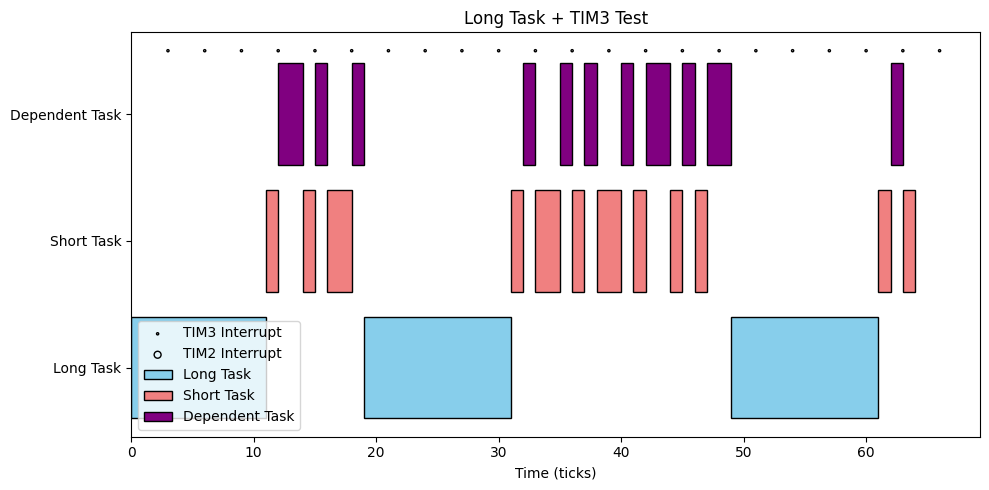

In [79]:

plot_rtos_log("long_task_tim3.txt", title="Long Task + TIM3 Test")


### Long tasks with interrupts from TIM2:

Long tasks are running, but TIM2 interrupts occur periodically, and will queue
up any tasks in queue, but since we didn't add short task in this test, the
queue is empty and no new task will be run, and the long task will continue to
run.


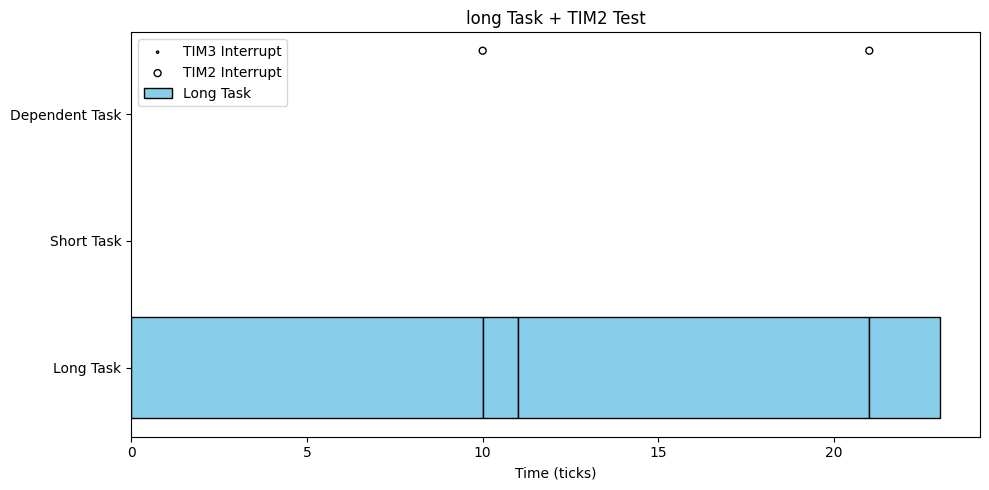

In [80]:

plot_rtos_log("long_tim2.txt", title="long Task + TIM2 Test")


### Short task only:

The queue initializes with a short task, which we expect that the dependent task
will immediately run after the short task finishes. However since no TIM2 or
TIM3 is present, no new tasks will be queued up.


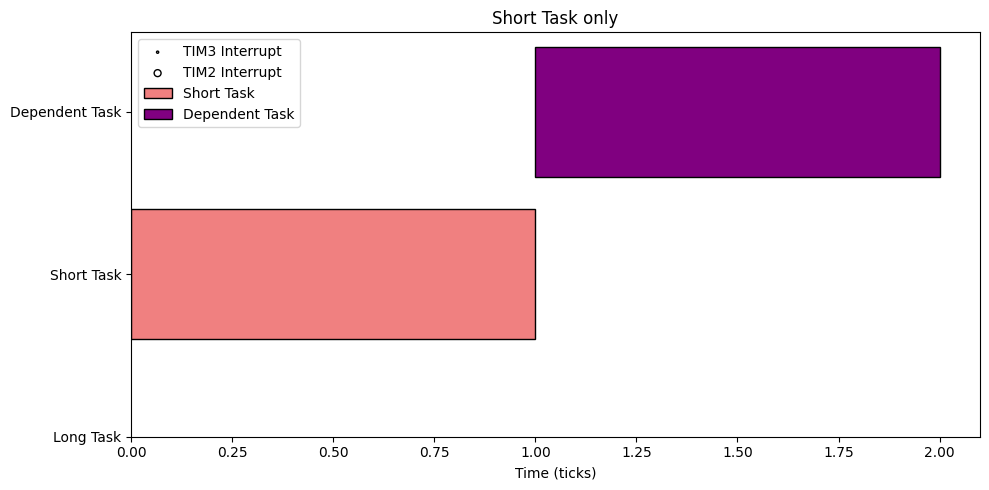

In [81]:

plot_rtos_log("short_task_only.txt", title="Short Task only")


### Short task with TIM3 interrupts:

The queue initializes with a short task, which we expect that the dependent task
will immediately run after the short task finishes. we also expect that the
short task gets added to the queue when tim3 interrupts happen, and gets run
every time the queue is not empty.


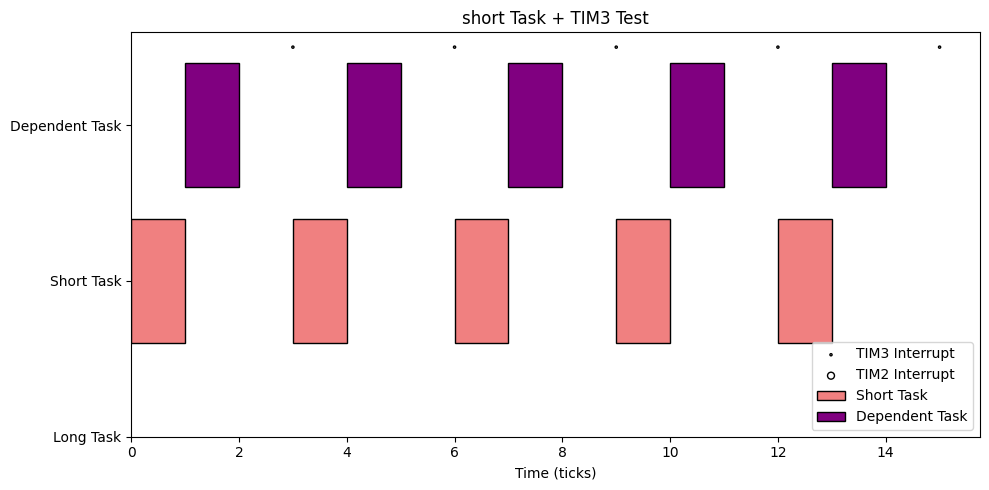

In [82]:

plot_rtos_log("short_tim3.txt", title="short Task + TIM3 Test")


### Short task with TIM2 interrupts:

Because the short task and the dependent task are shorter than the allocated
time in TIM2, we expect that they just run once and never gets interrupted. But
since TIM3 is not present, no tasks will be added after the initial short task
and dependent task gets run.


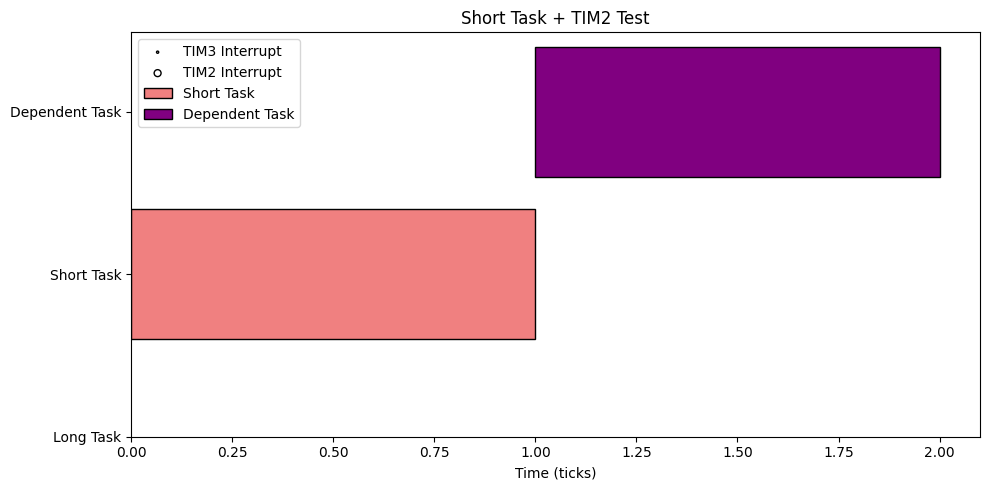

In [83]:

plot_rtos_log("short_tim2.txt", title="Short Task + TIM2 Test")


### Normal situation, Long task + TIM2 + TIM3:

This is the normal situation where we initialize the task queue with a long task
and with both TIM2 and TIM3 enabled. We expect to see that whenever TIM3 occurs,
the short task is queued. And whenever a short task finished running, a
dependent task runs. We also expect that TIM2 interrupts eonly ever interrupts
the long task since none of the short and dependent tasks are long enough to use
up all the allocated time slice. We also expect that when TIM2 interrupts
happen, the short tasks in the queue gets run.


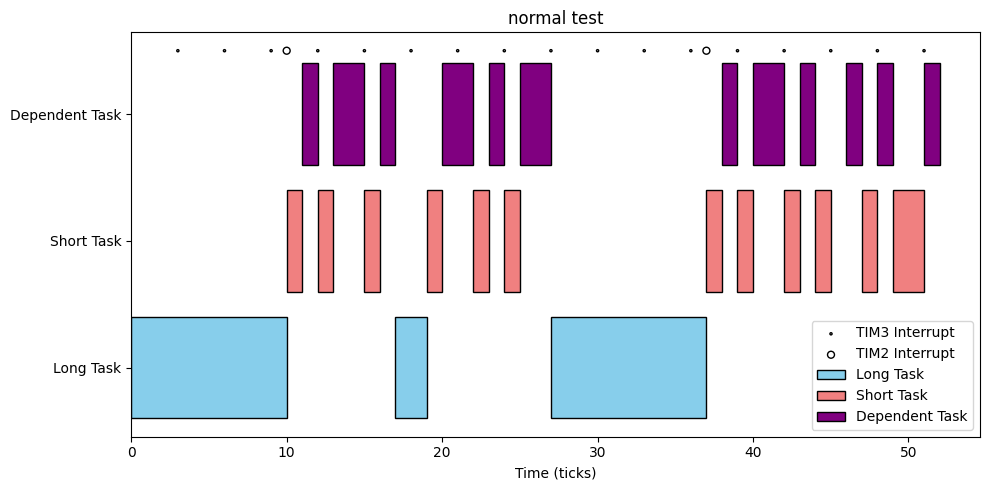

In [84]:
plot_rtos_log("three_task_data.txt", title="normal test")


### Initialize with no task with TIM2 + TIM3:

We expect to see no task in the beginning since we initialize the queue empty,
but we expect short task to run after TIM3 interrupts happen. We also expect
that TIM2 will not go off since no long task will be present.


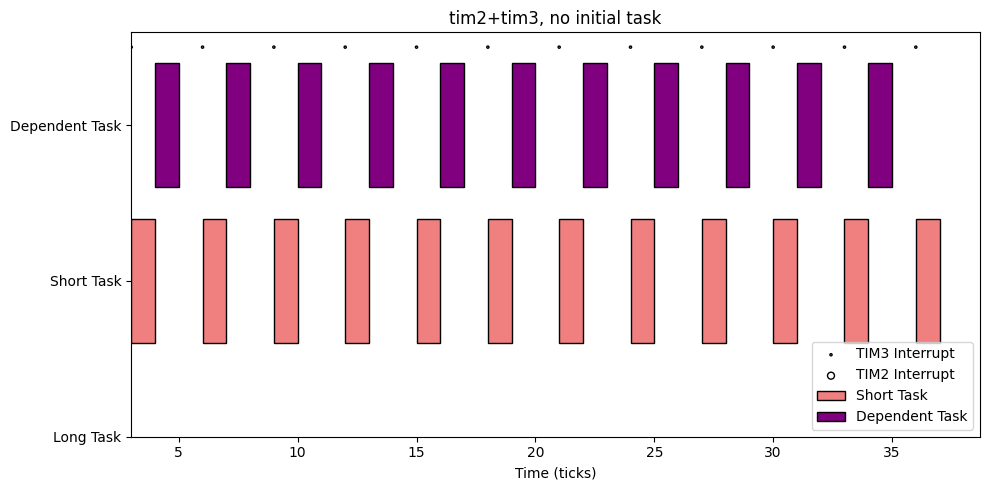

In [85]:

plot_rtos_log("tim2tim3_no_task.txt", title="tim2+tim3, no initial task")


### Initialize with no task, with TIM3

We expect to see the same behavior as the graph above, since the TIM2 in the
last test never gets triggered.


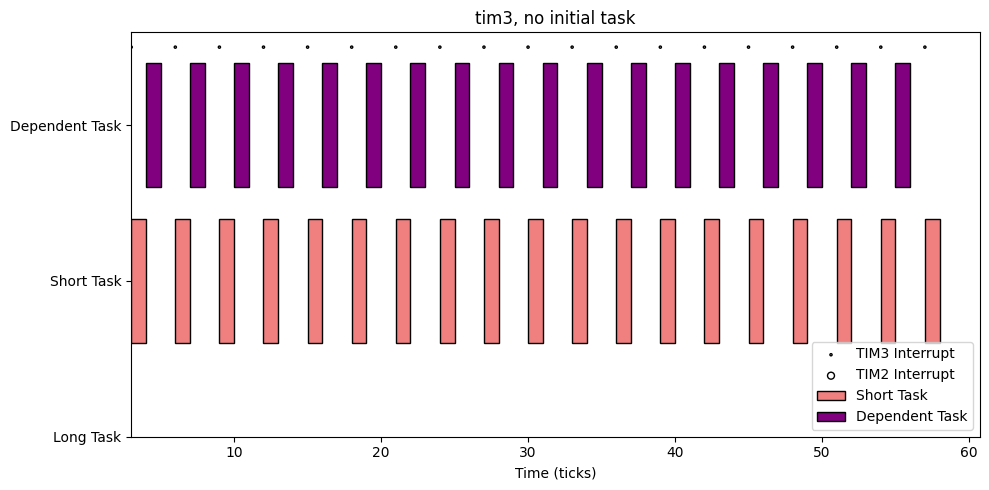

In [86]:


plot_rtos_log("tim3_no_task.txt", title="tim3, no initial task")
